# _Warm Gradient Descent_

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os
%matplotlib inline

In [2]:
np.random.seed(42)

In [3]:
os.makedirs("./images", exist_ok=True)

In [4]:
# In order to save figures

def save_fig(fig_id, resolution=300):
    path = os.path.join("./images", fig_id + ".png")
    print("Saving figure", fig_id)
    plt.savefig(path, format="png", dpi=resolution)

In [5]:
# Creating the data

m = 100

X = 2* np.random.rand(m,1)
y = 4 + 3 * X + np.random.randn(m,1)

Saving figure generated_data_plot


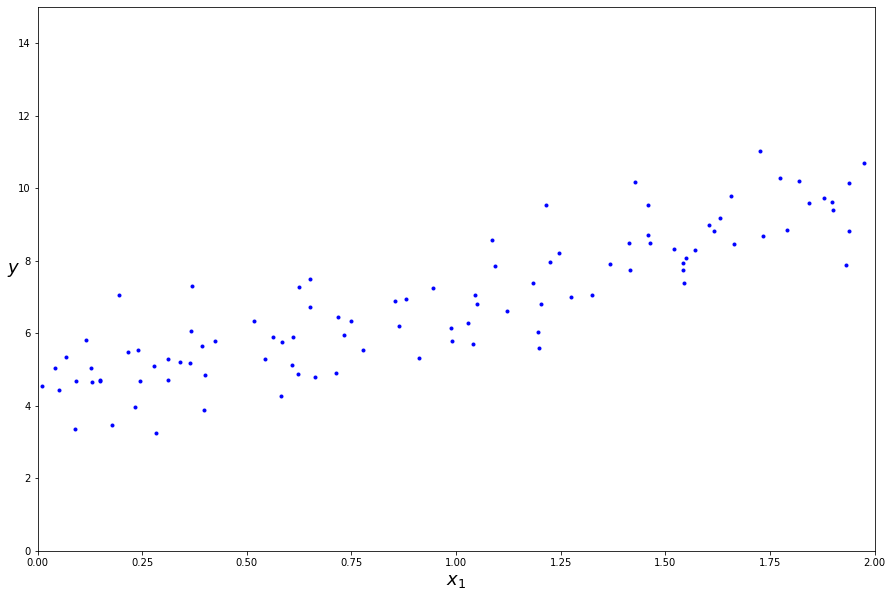

In [6]:
# Plotting the created data

plt.figure(figsize=(15,10))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

In [7]:
# Adding the bias term to the data

X_b = np.c_[np.ones((m, 1)), X]

In [8]:
# Creating new data to check predictions

X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)), X_new]

## Using scikit-learn

In [9]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [10]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

## using batch gradient descent

In [11]:
eta = 0.1
n_iterations = 1000

theta = np.random.randn(2,1) # Random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [12]:
theta

array([[4.21509616],
       [2.77011339]])

In [13]:
X_new_b.dot(theta)

array([[4.21509616],
       [9.75532293]])

## Stochastic gradient descent

In [14]:
np.random.seed(42)

In [15]:
n_epochs = 500
t0, t1 = 5, 50 #learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t+t1)

theta = np.random.randn(2,1) #random initialization

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta)-yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta*gradients

In [16]:
theta

array([[4.20883997],
       [2.76597896]])

## Mini-batch gradient descent

In [31]:
theta_path_mgd = []

m = 100 #size of the dataset
n_epochs =  50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1) #random initialization

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t+t1)

t = 0
for epoch in range(n_epochs):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1 
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta)-yi)
        eta = learning_schedule(t)
        theta = theta - eta*gradients
        theta_path_mgd.append(theta)

In [32]:
theta

array([[4.25214635],
       [2.7896408 ]])

In [33]:
theta_path_mgd = np.array(theta_path_mgd)

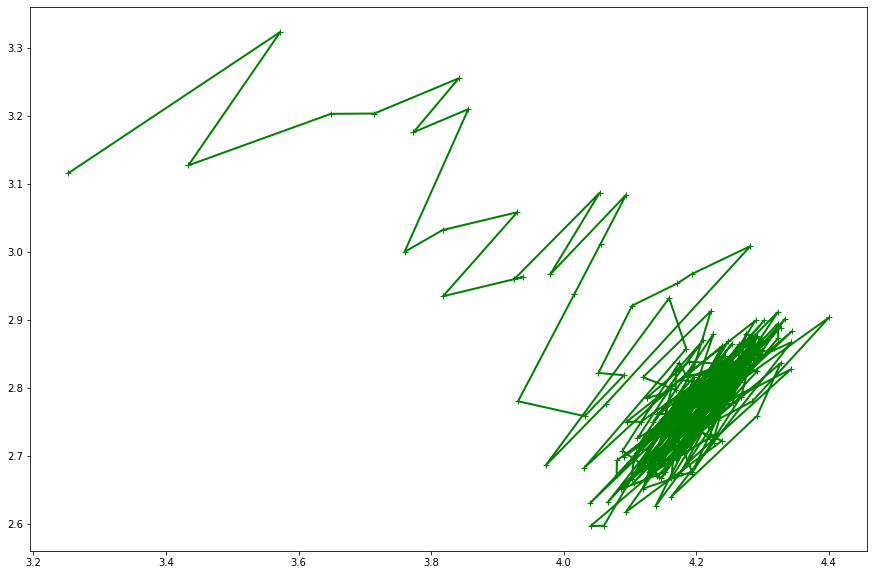

In [34]:
plt.figure(figsize=(15,10))
plt.plot(theta_path_mgd[:,0], theta_path_mgd[:,1], "g-+", linewidth=2, label="Batch")

## Warm Gradient Descent